In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <원 data set>

In [3]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

#### scasler

In [5]:
df_tgt = df.iloc[:,3:]

scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

#### static DF

In [6]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [7]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [8]:
# len(df.loc[df.ds<'2021-06-30'])

## <기준 날짜 및 예측 기간 설정>

In [9]:
cutoff_date = '2021-12-30' ## len = 65
test_period = 12

In [19]:
df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]][:test_period+1
                                                        ]

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
72,2022-01-31,A,43.260870,0.631414,0.318707,1.983558,1.463396,1.048823,0.916574,0.779937,...,2.677508,2.680955,2.665481,2.680401,2.510212,1.610945,1.608097,1.585530,1.586450,1.586450
73,2022-02-28,A,56.425000,1.270279,0.406105,2.294724,1.435042,1.467862,0.798730,1.945680,...,2.197789,2.207543,2.190755,2.181831,2.058747,1.168835,1.174279,1.163390,1.167415,1.167415
74,2022-03-31,A,71.086957,2.126927,1.148209,2.612162,1.241856,1.831557,1.195636,2.269497,...,2.026895,2.013125,2.037362,2.013198,1.906047,1.471655,1.468981,1.476677,1.477051,1.477051
75,2022-04-30,A,75.804348,2.687810,0.860751,2.556884,1.425830,2.242691,1.391677,2.722841,...,2.170896,2.152358,2.152352,2.132638,2.410643,2.259286,2.271036,2.255625,2.261700,2.261700
76,2022-05-31,A,74.295455,2.621695,1.713126,2.501607,1.892086,2.385006,1.329234,3.305713,...,1.814178,1.807191,1.810962,1.808275,2.410643,2.106495,2.106820,2.111163,2.116623,2.116623
77,2022-06-30,A,73.000000,2.389233,1.060177,2.515599,2.230336,2.471976,1.161657,3.111422,...,1.310465,1.314768,1.273957,1.284862,2.410643,1.628496,1.623594,1.607981,1.608344,1.608344
78,2022-07-31,A,73.000000,2.389233,0.691597,2.439292,2.526593,2.377100,0.921668,2.852368,...,1.464141,1.460176,1.481963,1.473009,2.410643,1.436494,1.434052,1.439497,1.441548,1.441548
79,2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,...,2.219001,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215
80,2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,...,2.107414,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251
81,2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,...,2.352264,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120


In [10]:
Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<cutoff_date])]] # 132 train
Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]][:test_period]

In [11]:
futr_temp = Y_test_df.drop(['y'], axis=1)
futr_list = [
             'Shanghai Containerized Freight Index (SCFI)',
             # '대두 [미국(생산자 가격)] 현물',
             # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
             '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
             'HOUSECOST_KOR'
             ]
futr_date = futr_temp.iloc[:,:2]
futr_df = pd.concat([futr_date,futr_temp[futr_list]], axis=1)
futr_df

,ds,unique_id,Shanghai Containerized Freight Index (SCFI),보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물,HOUSECOST_KOR
72,2022-01-31,A,1.463396,0.615542,1.201544
73,2022-02-28,A,1.435042,0.691497,1.201544
74,2022-03-31,A,1.241856,1.340240,1.201544
75,2022-04-30,A,1.425830,2.205393,1.973534
76,2022-05-31,A,1.892086,3.349814,1.973534
77,2022-06-30,A,2.230336,2.882313,1.973534
78,2022-07-31,A,2.526593,2.756979,2.733617
79,2022-08-31,A,2.773368,2.707425,2.733617
80,2022-09-30,A,3.024986,2.691681,2.733617
81,2022-10-31,A,3.036207,2.829549,3.198978


In [15]:
horizon = len(Y_test_df)

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=12, input_size=24,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,  
          #       futr_exog_list = futr_list,
          #       max_steps=100,
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                futr_exog_list = futr_list,
                # n_freq_downsample=[2, 1, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                max_epochs=200),
          # TFT(h=12, 
          #     input_size=5 * horizon,
          #     # hidden_size=20,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = futr_list,
          #     max_steps=100,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Epoch 0:  50%|██████████████▌              | 1/2 [00:00<00:00,  2.38it/s, loss=0.702, v_num=861, train_loss_step=0.702]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|██▌  | 1/2 [00:00<00:00, 14.59it/s, loss=0.671, v_num=861, train_loss_step=0.641, train_loss_epoch=0.702]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|██▌  | 1/2 [00:00<00:00, 13.87it/s, loss=0.643, v_num=861, train_loss_step=0.587, train_loss_epoch=0.641]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|██▌  | 1/2 [00:00<00:00, 13.16it/s, loss=0.616, v_num=861, train_loss_step=0.537, train_loss_epoch=0.587]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|██▌  | 1/2 [00:00<00:00, 16.67it/s, loss=0.597, v_num=861, train_loss_step=0.521, train_loss_epoch=0.537]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|██▌  | 1/2 [00:00<00:00, 15.38it/s, loss=0.579, v_num=861, train_loss_step=0.488, train_loss_epoch=0.521]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|██▌  | 1/2 [00:00<00:00, 13.51it/s, loss=0.561, v_num=861, train_loss_step=0.451

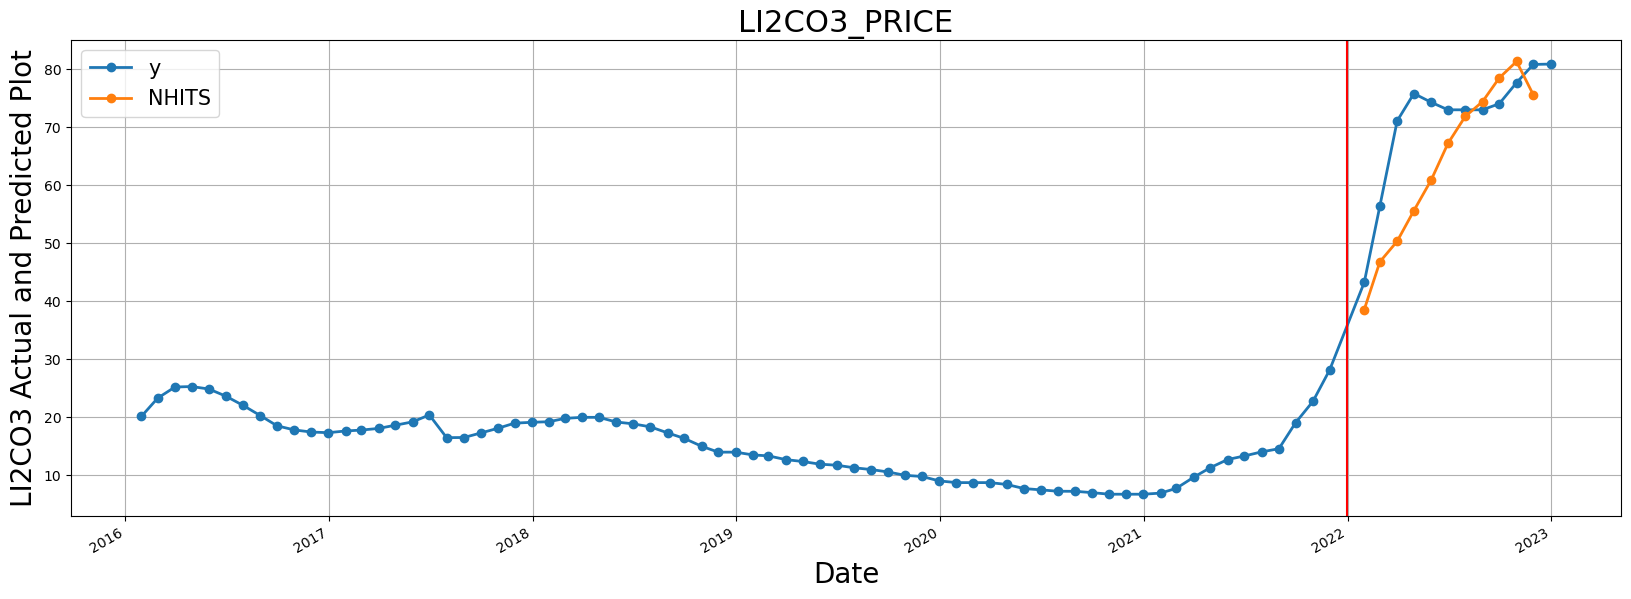

In [16]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
plt.axvline(cutoff_date, color='red')

ax.set_title('LI2CO3_PRICE', fontsize=22)
ax.set_ylabel('LI2CO3 Actual and Predicted Plot', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [18]:
plot_df[['y', 'NHITS']]

,y,NHITS
ds,,
2016-01-31,20.177268,NaN
2016-02-29,23.306868,NaN
2016-03-31,25.223010,NaN
2016-04-30,25.308243,NaN
2016-05-31,24.875099,NaN
...,...,...
2022-08-31,73.000000,74.403870
2022-09-30,74.047619,78.491814
2022-10-31,77.673913,81.328629
